In [92]:
# all the packages you need
from __future__ import division
import sys
import numpy as np
import time
import scipy.io as io
import scipy.sparse as sparse
import matplotlib.pyplot as plt
%matplotlib inline

In [93]:
# synthetic data generator
# n is number of samples, d is number of dimensions, k is number of nonzeros in w, sigma is std of noise, 
# X is a n x d data matrix, y=Xw+w_0+noise is a n-dimensional vector, w is the true weight vector, w0 is true intercept
def DataGenerator(n = 50, d = 75, k = 5, sigma = 1.0, w0 = 0.0, seed = 256):
    
    np.random.seed(seed)
    X = np.random.normal(0,1,(n,d))
    w = np.random.binomial(1,0.5,k)
    noise = np.random.normal(0,sigma,n)
    w[w == 1] = 10.0
    w[w == 0] = -10.0
    w = np.append(w, np.zeros(d - k))
    y = X.dot(w) + w0 + noise
    return (X, y, w, w0)

In [94]:
# initialization of W for lasso by least square regression or ridge regression
def Initialw(X, y):

    n, d = X.shape
    # increment X
    if sparse.issparse(X):
        XI = sparse.hstack((X, np.ones(n).reshape(n,1))) 
        # stack a matrix and a column
    else:
        XI = np.hstack((X, np.ones(n).reshape(n,1)))

    if sparse.issparse(X):
        if n >= d:
            w = sparse.linalg.lsqr(XI, y)[0]
            # finds the least square solution to a linear system: W*XI=y
            # n >= d: close-form exists
        else:
            w = sparse.linalg.inv(XI.T.dot(XI) + 1e-3 * sparse.eye(d+1)).dot(XI.T.dot(y))
            # (X^T X + \epsilon)^(-1) X^T y
            # n < d: only approximation exists
            w = w.T
    else:
        if n >= d:
            w = np.linalg.lstsq(XI, y)[0]
            # least square solution
        else:
            w = np.linalg.inv(XI.T.dot(XI) + 1e-3 * np.eye(d+1)).dot(XI.T.dot(y))
 
    return (w[:d], w[d])

In [95]:
# Helper and example function of sparse matrix operation for Problem 2.5
# W: a scipy.sparse.csc_matrix
# x: a vector with length equal to the number of columns of W
# In place change the data stored in W,
# so that every row of W gets element-wise multiplied by x
def cscMatInplaceEleMultEveryRow(W, x):
    indptr = W.indptr
    last_idx = indptr[0]
    for col_id, idx in enumerate(indptr[1:]):
        if idx == last_idx:
            continue
        else:
            W.data[last_idx:idx] *= x[col_id]
            last_idx = idx

In [96]:
# Sub-Problem 1
# TODO: coordinate descent of lasso, note lmda stands for lambda
def F(XI, y, W, lmda):
    diff = np.matmul(XI, W) - y
    loss = 0.5 * np.matmul(diff.T, diff) + lmda * np.sum(np.abs(W[:-1]))
    return loss

def lasso(X, y, lmda = 10.0, epsilon = 1.0e-2, max_iter = 100, draw_curve = False):
    #########TODO##########
    w, w0 = Initialw(X, y)
    n, d = X.shape
    W = np.hstack((w, w0))
    XI = np.hstack((X, np.ones(n).reshape(n,1)))
    iterations = []
    losses = []
    for i in range(max_iter):
        tmp = np.copy(W)
        for j in range(d + 1):
            mask = np.hstack((np.arange(j), np.arange(j + 1, d + 1)))
            #print(mask)
            r = y - np.matmul(XI[:, mask], W[mask])
            a = np.dot(XI[:, j].T, XI[:, j])
            c = np.dot(r, XI[:, j])
            last = W[j]
            if c < -lmda:
                W[j] = (c + lmda) / a
            elif c > lmda:
                W[j] = (c - lmda) / a
            else:
                W[j] = 0
        iterations.append(i + 1)
        loss = F(XI, y, W, lmda)
        losses.append(loss)
        if (np.abs(W - tmp) <= epsilon).all():
            #print(i)
            break
    if draw_curve:
        plt.plot(iterations, losses)
        plt.xlabel('iterations')
        plt.ylabel('F(theta)')
        plt.savefig('figs/2.1.pdf')
        plt.show()
    w, w0 = W[:d], W[d]
    return (w, w0)

In [305]:
# Sub-Problem 1: data generation
n = 100
m = 150

X, y, w_true, w0_true = DataGenerator(n=n, d=m, k=5, sigma=1.0, w0=0.0)
# have a look at generated data and true model
print(X)
print(y)
print(w_true)
print(w0_true)

[[ 0.10430293 -0.55011253 -0.07271465 ...  0.54423528 -0.12555319
   0.29833038]
 [-0.93920808 -0.88460697 -0.36846914 ... -0.50546019 -0.04159342
  -0.01291595]
 [ 0.31860678  0.09803393  0.79127714 ...  0.84931761 -0.42616459
   0.76857532]
 ...
 [ 0.55546365  0.84917102 -0.82208175 ... -2.03365761  0.28594759
   0.30328844]
 [-0.31075096  0.86697979 -0.2050817  ...  0.132073   -1.3469008
  -0.29268038]
 [ 2.51943233  1.03025557 -0.30999576 ... -2.86031678 -0.43470702
   1.70951079]]
[-7.93452268e+00 -6.87566861e+00  5.68374639e-02 -1.94470223e+01
  1.87131844e+01  4.20497625e+01  6.90698646e+00  2.03785690e+01
  1.78108400e+01  4.65235311e+00  2.63299434e+01 -1.90828279e+01
  3.02355009e+01 -3.04834891e+00  2.90505728e+01 -7.77200894e+00
 -1.93982280e+01 -2.77393652e+00  5.07843132e+00  2.23407469e+01
 -1.34518275e+01  1.11170455e+01 -9.41918304e+00 -3.00534897e+01
 -1.51874463e+01 -3.05091015e+01 -1.63346731e+01  2.72735794e+00
 -1.68427630e+01 -2.30655049e+01 -2.30117919e+01 -1.04

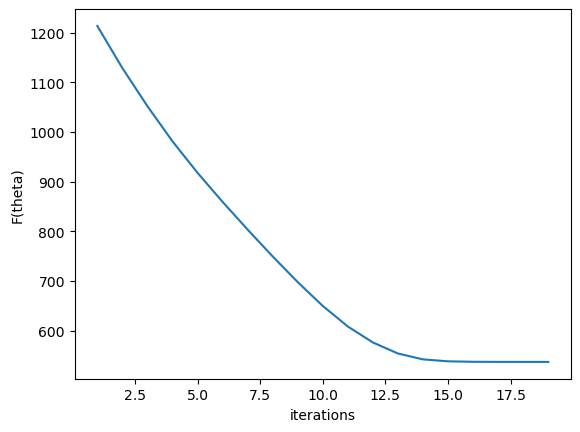

[ 1.00585568e+01  9.64936274e+00 -9.84619755e+00 -9.75179575e+00
  1.00053133e+01 -8.17652886e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.28577986e-02
  0.00000000e+00  0.00000000e+00  4.31362256e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -2.34598325e-03  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  5.23757119e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.95527620e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.18464847e-02  0.00000000e+00
 -1.61033321e-02  0.00000000e+00 -4.45354698e-02 -1.01744159e-02
  0.00000000e+00 -4.57422227e-03  0.00000000e+00  0.00000000e+00
 -4.62366381e-02  1.58481

In [306]:
# Sub-Problem 1: run lasso and plot the convergence curve
# TODO: run lasso for one synthetic data
w_lasso, w0_lasso = lasso(X, y, lmda = 10.0, epsilon = 1.0e-2, draw_curve = True, max_iter = 100)
# have a look at the lasso model you got (sparse? where?)
print(w_lasso)
print(w0_lasso)
print([i for i in range(len(w_lasso)) if np.abs(w_lasso[i]) > 1.1e-1])
print([i for i in range(len(w_true)) if w_true[i] != 0])

In [307]:
# Sub-Problem 2
# TODO: evaluation function of lasso model
def Evaluate(X, y, w, w0, w_true, w0_true):
    #########TODO##########
    non_zero = set([i for i in range(len(w)) if w[i] != 0])
    non_zero_true = set([i for i in range(len(w_true)) if w_true[i] != 0])
    intersection = non_zero.intersection(non_zero_true)
    if len(non_zero) > 0:
        precision_w = len(intersection) / len(non_zero)
    else:
        precision_w = 1
    if len(non_zero_true) > 0:
        recall_w = len(intersection) / len(non_zero_true)
    else:
        precision_w = 1

    sparsity_w = len(non_zero)

    n = X.shape[0]
    y_hat = np.matmul(X, w) + w0
    diff = y_hat - y
    rmse = np.sqrt(np.dot(diff.T, diff) / n)
    return (rmse, sparsity_w, precision_w, recall_w)

In [308]:
# Sub-Problem 2
# TODO: apply your evaluation function to compute precision (of w), recall (of w), sparsity (of w) and training RMSE
Emetric = Evaluate(X, y, w_lasso, w0_lasso, w_true, w0_true)
print('rmse={}'.format(Emetric[0]))
print('sparsity={}'.format(Emetric[1]))
print('precision={}'.format(Emetric[2]))
print('recall={}'.format(Emetric[3]))

rmse=0.7786786147829086
sparsity=38
precision=0.13157894736842105
recall=1.0


1020.190583947795


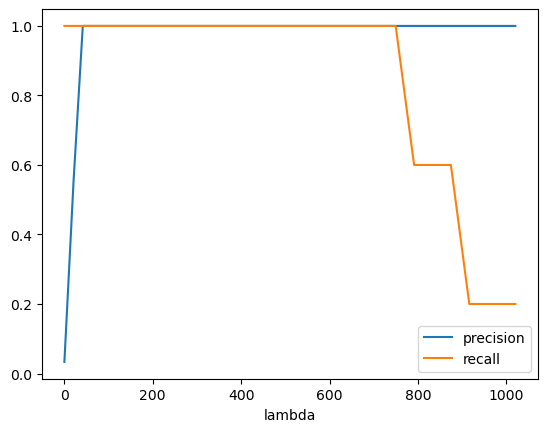

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


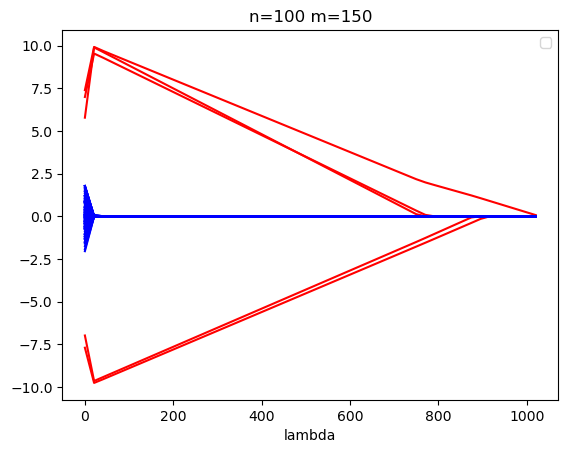

In [309]:
# Sub-Problem 3
# TODO: compute a lasso solution path, draw the path(s) in a 2D plot
def try_lmda(X, y, w_true, w0_true, draw_curve = False):
    y_diff = (y - np.mean(y)).reshape(y.shape[0], -1)
    #lmda_max = np.max(np.abs(np.matmul(y_diff.T, X)))
    lmda_max = np.max(np.abs((y - np.mean(y)).dot(X)))
    #lmda_max = 1050
    print(lmda_max)
    lmda_min = 0
    lmdas = np.linspace(lmda_min, lmda_max, num = 50)
    precisions = []
    recalls = []
    W = np.zeros((X.shape[1], 50))
    W0 = np.zeros(50)
    for idx, lmda in enumerate(lmdas):
        w_lasso, w0_lasso = lasso(
            X, y, 
            lmda = lmda, epsilon = 1.0e-2,
            draw_curve = False, max_iter = 100)
        emetric = Evaluate(X, y, w_lasso, w0_lasso, w_true, w0_true)
        precisions.append(emetric[2])
        recalls.append(emetric[3])

        W[:, idx] = w_lasso
        W0[idx] = w0_lasso
        
    if draw_curve:
        plt.plot(lmdas, precisions)
        plt.plot(lmdas, recalls)
        plt.xlabel('lambda')
        plt.legend(['precision', 'recall'])
        plt.savefig('figs/2.3.1n={}m={}.pdf'.format(n, m))
        plt.show()

        for i in range(X.shape[1]):
            if w_true[i] != 0: 
                plt.plot(lmdas, W[i, :], c = 'r')
            else:
                plt.plot(lmdas, W[i, :], c = 'b')
        if w0_true != 0:
            plt.plot(W0, c = 'r')
        else:
            plt.plot(W0, c = 'b')
        plt.legend()
        plt.title('n={} m={}'.format(n, m))
        plt.xlabel('lambda')
        plt.savefig('figs/2.3.2n={}m={}.pdf'.format(n, m))
        plt.show()
    
try_lmda(X, y, w_true, w0_true, draw_curve = True)

def LassoPath(X, y):
    #########TODO##########
    num_lmda = 50
    W = np.zeros((X.shape[1], num_lmda))
    W0 = np.zeros(num_lmda)

    y_diff = (y - np.mean(y)).reshape(y.shape[0], -1)
    #lmda_max = np.max(np.matmul(y_diff.T, X))
    lmda_max = np.max(np.abs((y - np.mean(y)).dot(X)))
    lmda_min = 0
    Lmda = np.linspace(lmda_min, lmda_max, num = num_lmda)

    for idx, lmda in enumerate(Lmda):
        w_lasso, w0_lasso = lasso(
            X, y, 
            lmda = lmda, epsilon = 1.0e-2,
            draw_curve = False, max_iter = 100)
        W[:, idx] = w_lasso
        W0[idx] = w0_lasso

    for i in range(X.shape[1]):
        if w_true[i] != 0: 
            plt.plot(Lmda, W[i, :], c = 'r')
        else:
            plt.plot(Lmda, W[i, :], c = 'b')
    if w0_true != 0:
        plt.plot(W0, c = 'r')
    else:
        plt.plot(W0, c = 'b')
    plt.legend()
    plt.xlabel('lambda')
    plt.savefig('figs/2.3.2n={}m={}.pdf'.format(n, m))
    plt.show()

    return (W, W0, Lmda)

#LassoPath(X, y)

In [310]:
# Sub-Problem 3
# TODO: evaluate a given lasso solution path, draw plot of precision/recall vs. lambda
def EvaluatePath(X, y, W, W0, w_true, w0_true, Lmda):
    #########TODO##########
    return (RMSE, Sparsity, Precision, Recall)

In [311]:
# Sub-Problem 3
# TODO: draw lasso solution path and precision/recall vs. lambda curves
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=1.0)

In [312]:
# Sub-Problem 3
# TODO: try a larger std sigma = 10.0
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=10.0)

In [313]:
# Sub-Problem 4
# TODO: try another 5 different choices of (n,d) 
# draw lasso solution path and precision/recall vs. lambda curves, use them to estimate the lasso sample complexity
X, y, w_true, w0_true = DataGenerator(n=50, d=150, k=5, sigma=1.0)

In [314]:
# Sub-Problem 5: predict reviews' star on Yelp
# data parser reading yelp data
def DataParser(Xfile, yfile, nfile, train_size = 4000, valid_size = 1000):

    # read X, y, feature names from file
    fName = open(nfile).read().splitlines()
    y = np.loadtxt(yfile, dtype=np.int32)
    if Xfile.find('mtx') >= 0:
        # sparse data
        X = io.mmread(Xfile).tocsc()
    else:
        # dense data
        X = np.genfromtxt(Xfile, delimiter=",")

    # split training, validation and test set
    X_train = X[0 : train_size,:]
    y_train = y[0 : train_size]
    X_valid = X[train_size : train_size + valid_size,:]
    y_valid = y[train_size : train_size + valid_size]
    X_test = X[train_size + valid_size : np.size(X,0),:]
    y_test = y[train_size + valid_size : np.size(y,0)]

    return (X_train, y_train, X_valid, y_valid, X_test, y_test, fName)

In [315]:
# Sub-Problem 5: predict reviews' star on Yelp
# TODO: evaluation funtion that computes the lasso path, evaluates the result, and draws the required plots
def Validation(X_train, y_train, X_valid, y_valid):
    #########TODO##########
    return (w_lasso, w0_lasso, lmda_best)

In [316]:
# Sub-Problem 5: predict reviews' star on Yelp
# TODO: evaluation of your results

# load Yelp data: change the address of data files on your own machine if necessary ('../data/' in the below)
import numpy as np
from scipy.sparse.linalg import lsqr
X_train, y_train, X_valid, y_valid, X_test, y_test, fName = DataParser('../data/star_data.mtx', '../data/star_labels.txt', '../data/star_features.txt', 30000, 5000)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)

# evaluation
w_lasso, w0_lasso, lmda_best = Validation(X_train, y_train, X_valid, y_valid)

# print the top-10 features you found by lasso
idx = (-np.abs(w_lasso)).argsort()[0:10]
print('Lasso select features:')
for i in range(10):
    print(fName[idx[i]],w_lasso[idx[i]])

FileNotFoundError: [Errno 2] No such file or directory: '../data/star_features.txt'